no1
score: 0.7637123026841103
0.00021463462131978244
0.00021463462131978244


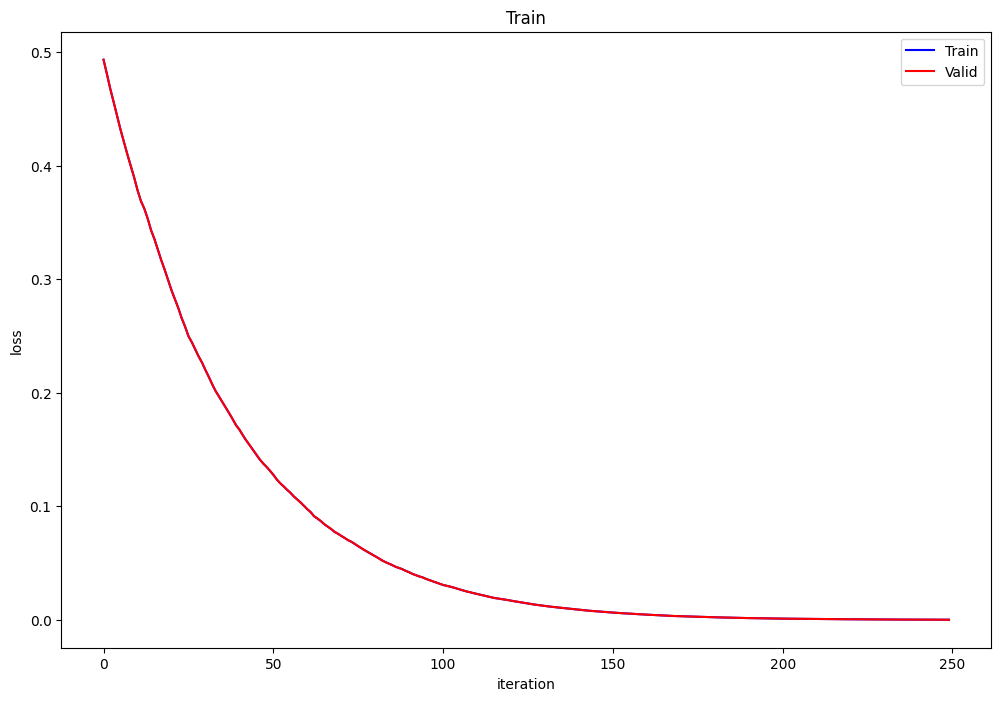

no2
score: 0.7637737239727289
0.7764735120772173
0.7711302600966049


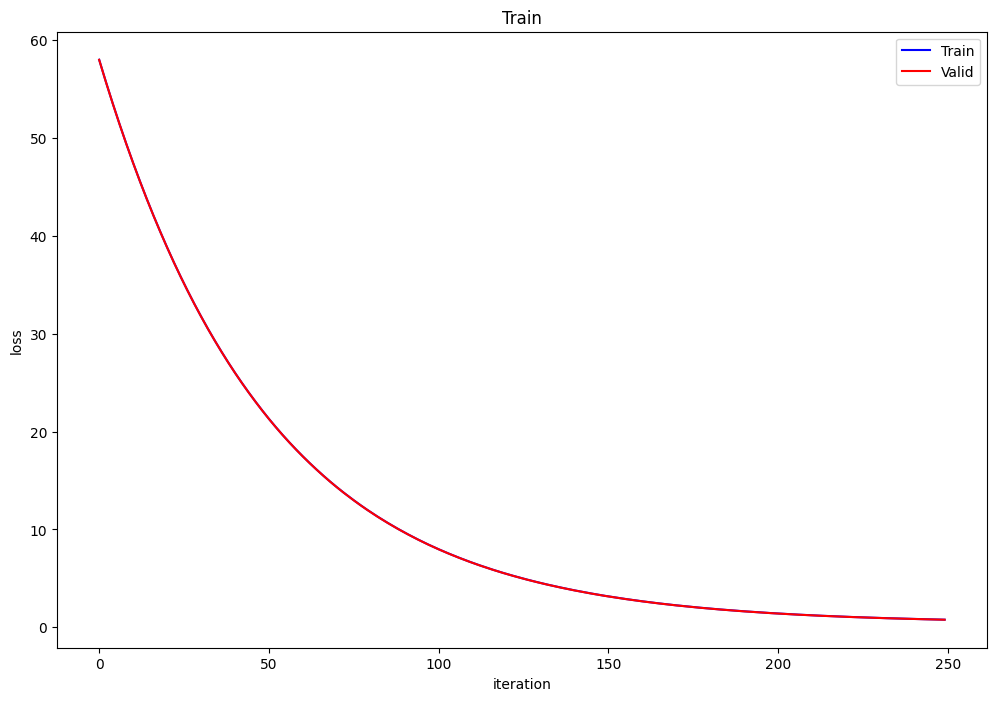

no3
score: 0.7522265217124255
0.040580043618510184
0.040580043618510184


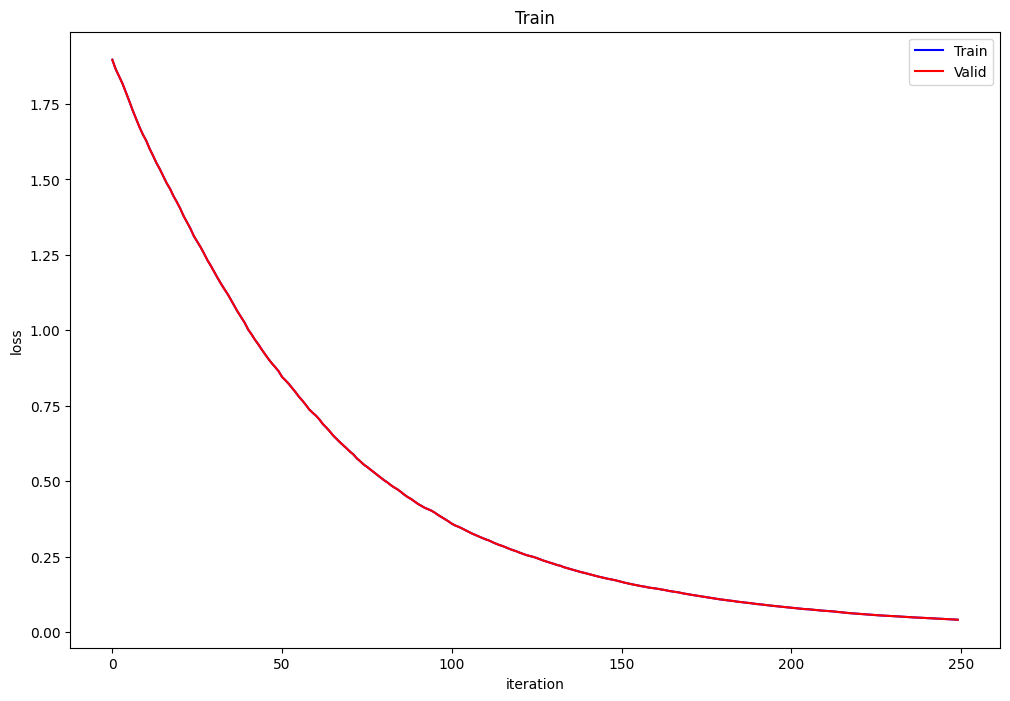

no4
score: 0.7637737239727289
0.7227989382706845
0.7189270634025


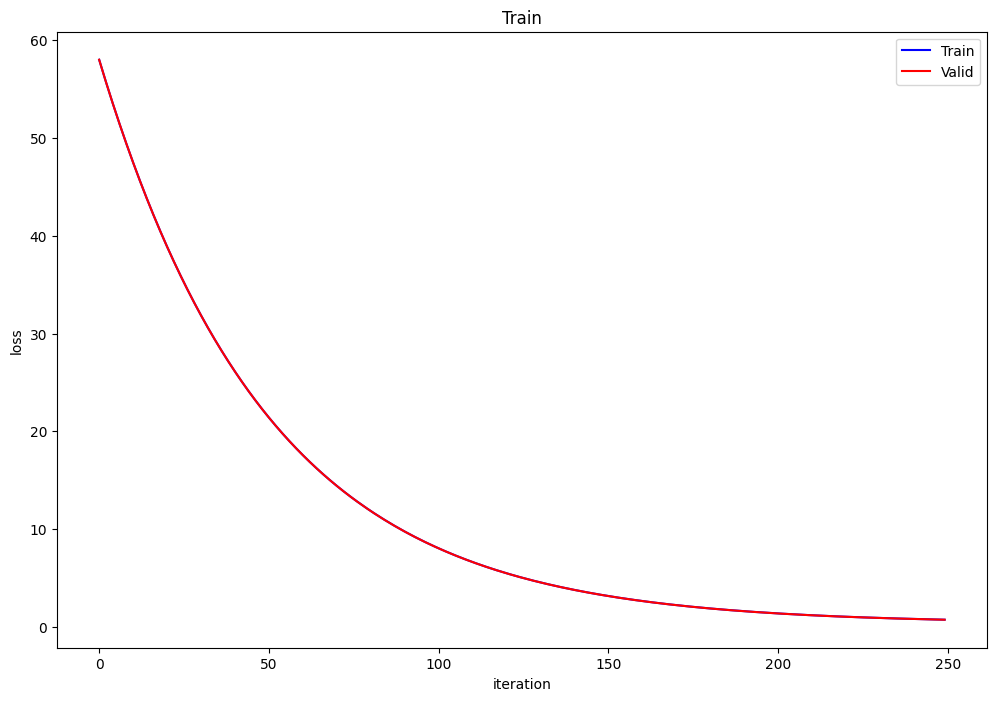

no5
score: 0.7637737239727289
-2.718883752388175e-06
-2.718883752388175e-06


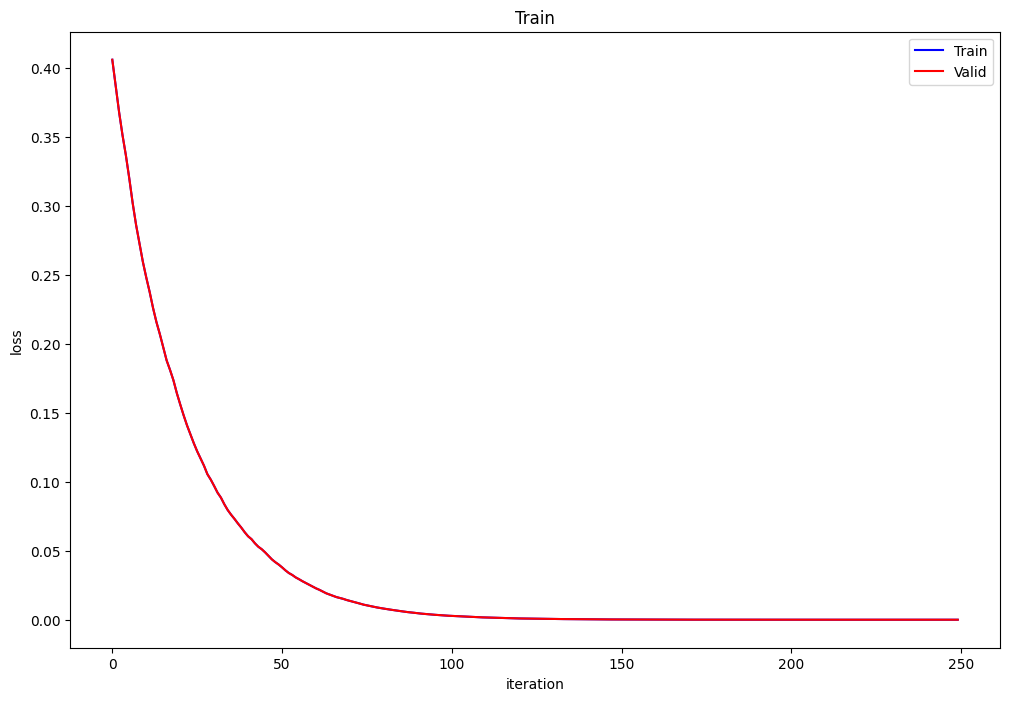

no6
score: 0.7637737239727289
0.7371745548419213
0.7322252181895548


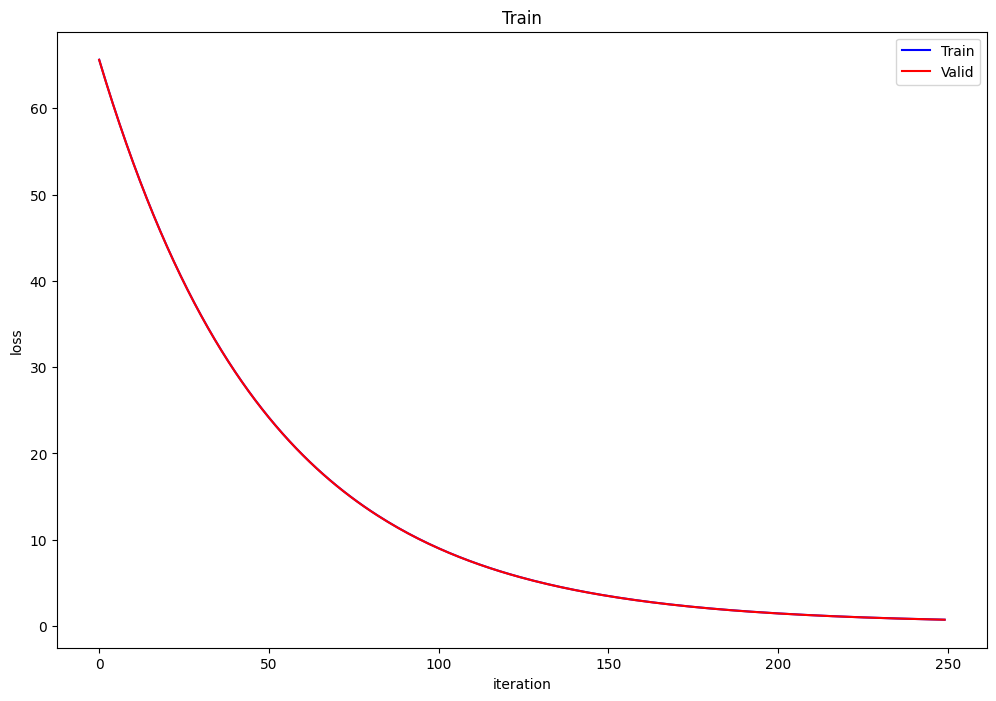

no7
score: 0.7637737239727289
58.44032578206922
58.42566850669479


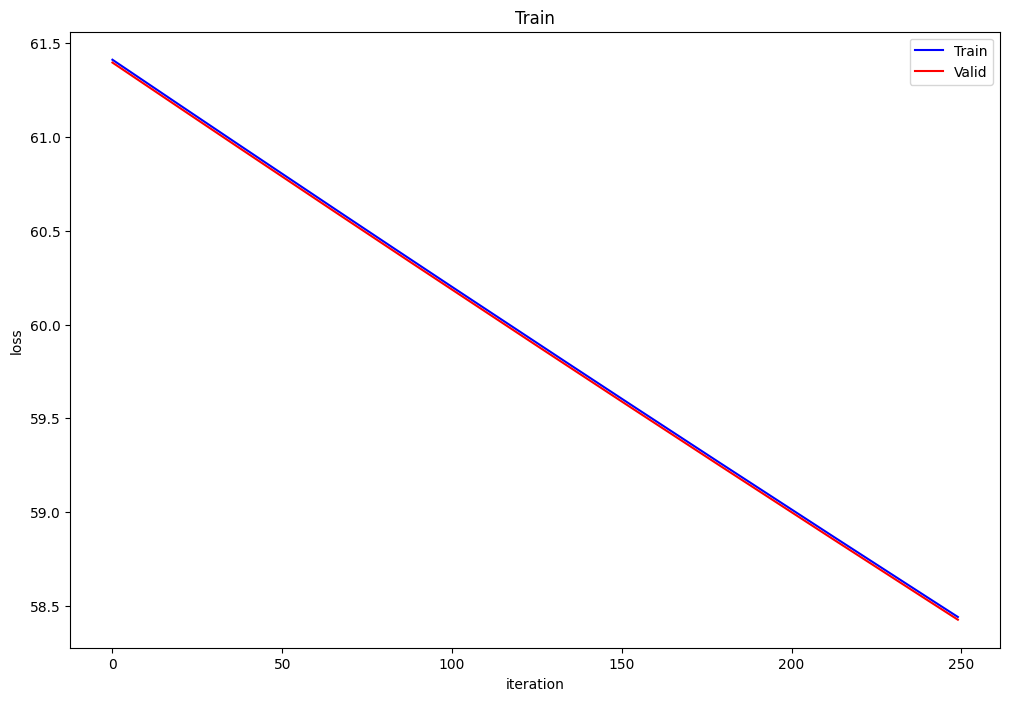

no8
score: 0.7637737239727289
0.634226731994543
0.6334186568688711


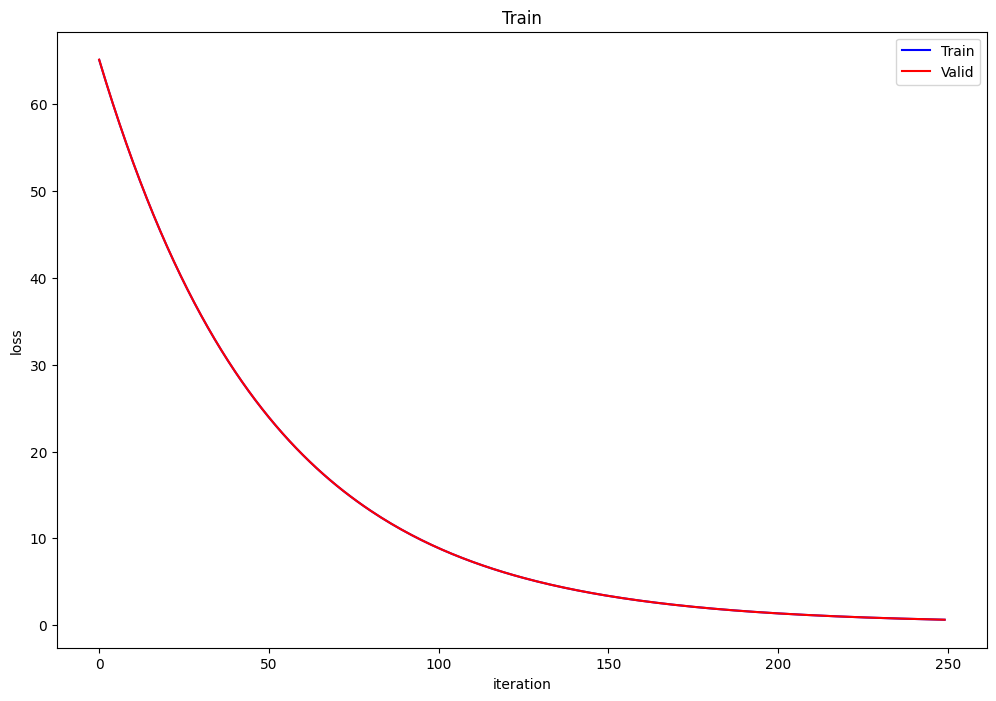

no9
score: 0.6143357287635894
0.3905682200482396
0.3905682200482396


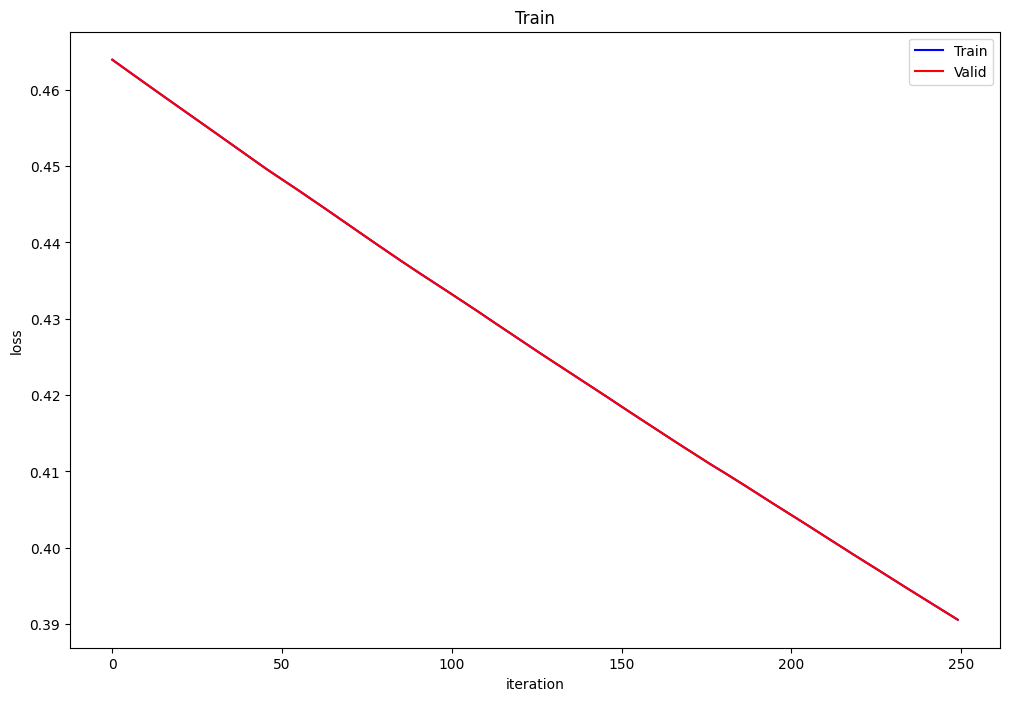

no10
score: 0.7637737239727289
1.3825284757588054
1.3782752709891657


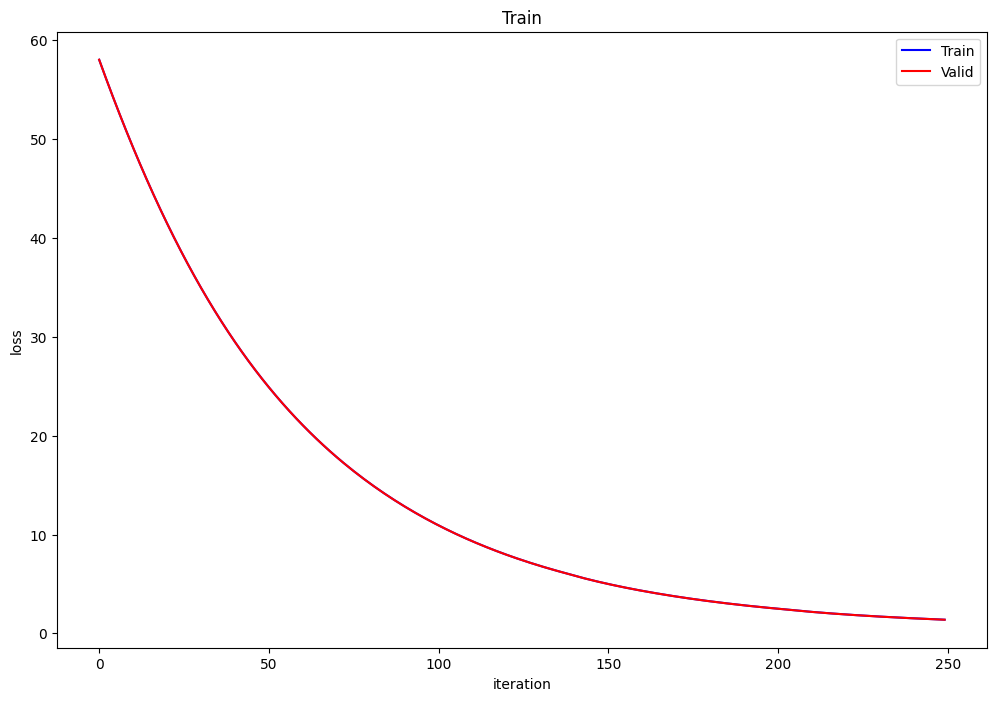

In [42]:
import numpy as np
import pandas as pd
import sklearn.datasets as sd
import sklearn.model_selection as sms
import matplotlib.pyplot as plt
import random

# 读取实验训练集和验证集
X_train, y_train = sd.load_svmlight_file('../data/a9a.txt',n_features = 123)
X_valid, y_valid = sd.load_svmlight_file('../data/a9a.t.txt',n_features = 123)


# 将稀疏矩阵转为ndarray类型
X_train = X_train.toarray()#转化为矩阵
X_valid = X_valid.toarray()
y_train = y_train.reshape(len(y_train),1)#转为列向量
y_valid = y_valid.reshape(len(y_valid),1)

#X_train.shape[0]返回数组的大小在数据前面多加一列1
X_train = np.concatenate((np.ones((X_train.shape[0],1)), X_train), axis = 1)#给x矩阵多增加1列1，拼接在每一行的末尾
X_valid = np.concatenate((np.ones((X_valid.shape[0],1)), X_valid), axis = 1)

#定义sigmoid函数，传入参数为向量时，对向量的每个参数进行运算后返回一个列表
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

#定义 logistic loss 函数
def logistic_loss(X, y ,theta):
    hx = sigmoid(X.dot(theta))
    cost = np.multiply((1+y), np.log(1+hx)) + np.multiply((1-y), np.log(1-hx))
    return -cost.mean()/2

#定义 logistic gradient 函数
def logistic_gradient(X, y, theta):
    return X.T.dot(sigmoid(X.dot(theta)) - y)

#定义 hinge loss 函数
def hinge_loss(X, y, theta, t):
    loss = np.maximum(0, 1 - np.multiply(y, X.dot(theta))).mean()
    reg = np.multiply(theta,theta).sum() / 2
    return t * loss + reg

#定义 hinge gradient 函数
def hinge_gradient(X, y, theta, C):
    error = np.maximum(0, 1 - np.multiply(y, X.dot(theta)))
    index = np.where(error==0)
    x = X.copy()
    x[index,:] = 0
    grad = theta - C * x.T.dot(y) / len(y)
    grad[-1] = grad[-1] - theta[-1]
    return grad

# 定义adam优化类
class Adam_optimizer:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = 0
        self.v = 0
        self.t = 0

    def optimize(self, parameters, gradients):
        self.t += 1
        self.m = self.beta1 * self.m + (1 - self.beta1) * gradients
        self.v = self.beta2 * self.v + (1 - self.beta2) * (np.power(gradients, 2))
        m_hat = self.m / (1 - self.beta1 ** self.t)
        v_hat = self.v / (1 - self.beta2 ** self.t)
        update = self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)
        parameters -= update
        return parameters




# 定义梯度下降框架
class Regression_frame(Adam_optimizer):
    def __init__(self,x_train,x_valid,y_train,y_valid,loss_func,gradient):
        super().__init__()
        self.x_train = x_train
        self.x_valid = x_valid
        self.y_train = y_train
        self.y_valid = y_valid
        self.loss_func = loss_func
        self.gradient = gradient
        self.theta = 0 # 初始化
        self.loss_train = []
        self.loss_valid = []
        
    # 线性模型参数初始化
    def init_params(self, mode="zero"):
        if mode == "zero": # 零初始化
            self.theta = np.zeros((self.x_train.shape[1],1))
        elif mode == "normal": # 正态分布初始化
            self.theta = np.random.normal(0,1,(self.x_train.shape[1],1))
        elif mode == "random": # 随机初始化
            self.theta = np.random.rand(self.x_train.shape[1],1)
                                  
    #线性回归随机梯度下降
    def linear_random_descent(self, alpha, iters, is_adam = False):
        self.learning_rate = alpha
        n=self.x_train.shape
        self.loss_train = np.zeros((iters,1))
        self.loss_valid = np.zeros((iters,1))
        for i in range(iters):
            #随机选择一个样本
            num=np.random.randint(n,size=1)
            x_select=self.x_train[num,:]
            y_select=self.y_train[num,0]
            grad = self.gradient(x_select, y_select, self.theta)
            if is_adam == True:# 是否使用adam优化
                self.theta = self.optimize(self.theta,grad)
            else:
                self.theta = self.theta - alpha * grad
            self.loss_train[i] = self.loss_func(self.x_train, self.y_train, self.theta)
            self.loss_valid[i] = self.loss_func(self.x_valid, self.y_valid, self.theta)
        return self.theta, self.loss_train, self.loss_valid

    #线性回归全梯度下降
    def linear_descent(self, alpha, iters, is_adam = False):
        self.learning_rate = alpha
        self.loss_train = np.zeros((iters,1))
        self.loss_valid = np.zeros((iters,1))
        for i in range(iters):
            grad = self.gradient(self.x_train, self.y_train, self.theta)
            if is_adam == True:# 是否使用adam优化
                self.theta = self.optimize(self.theta,grad)
            else:
                self.theta = self.theta - alpha * grad
            self.loss_train[i] = self.loss_func(self.x_train, self.y_train, self.theta)
            self.loss_valid[i] = self.loss_func(self.x_valid, self.y_valid, self.theta)
        return self.theta, self.loss_train, self.loss_valid
    
    #逻辑回归小批量梯度下降
    def logistic_descent(self, alpha, iters, batch_size, is_adam = False):
        self.learning_rate = alpha
        self.loss_train = np.zeros((iters,1))
        self.loss_valid = np.zeros((iters,1))
        data = np.concatenate((self.y_train, self.x_train), axis=1)
        for i in range(iters):
            sample = np.matrix(random.sample(data.tolist(), batch_size))
            grad = self.gradient(sample[:,1:125], sample[:,0], self.theta)#梯度
            if is_adam == True:# 是否使用adam优化
                self.theta = self.optimize(self.theta,grad)
            else:
                self.theta = self.theta - alpha * grad
            self.loss_train[i] = self.loss_func(self.x_train, self.y_train, self.theta)
            self.loss_valid[i] = self.loss_func(self.x_train, self.y_train, self.theta)
        return self.theta, self.loss_train, self.loss_valid
    
    #定义sigmoid函数，传入参数为向量时，对向量的每个参数进行运算后返回一个列表
    def sigmoid(self,z):
        return 1 / (1 + np.exp(-z))
    
    #定义 logistic score 函数
    def logistic_score(self, threshold):
        hx = self.sigmoid(self.x_valid.dot(self.theta))
        hx[hx>=threshold] = 1
        hx[hx<threshold] = -1
        hx = (hx==self.y_valid)
        return np.mean(hx)
    
    #定义 svm decent 函数
    def svm_descent(self, alpha, iters, batch_size, C, is_adam = False):
        self.learning_rate = alpha
        self.loss_train = np.zeros((iters,1))
        self.loss_valid = np.zeros((iters,1))
        data = np.concatenate((self.y_train, self.x_train), axis=1)
        for i in range(iters):
            sample = np.matrix(random.sample(data.tolist(), batch_size))
            grad = self.gradient(sample[:,1:125], sample[:,0], self.theta, C)
            if is_adam == True:# 是否使用adam优化
                self.theta = self.optimize(self.theta,grad)
            else:
                self.theta = self.theta - alpha * grad
            self.loss_train[i] = self.loss_func(self.x_train, self.y_train, self.theta, C)
            self.loss_valid[i] = self.loss_func(self.x_valid, self.y_valid, self.theta, C)
        return self.theta, self.loss_train, self.loss_valid
    
    #定义 svm score 函数
    def svm_score(self, threshold):
        hx = self.x_valid.dot(self.theta)
        hx[hx>=threshold] = 1
        hx[hx<threshold] = -1
        hx = (hx==self.y_valid)
        return np.mean(hx)
    
    # 输出最小loss并且画图
    def getLoss_and_plot(self, iters):
        print(self.loss_train.min())
        print(self.loss_valid.min())
        iteration = np.arange(0, iters, step = 1)
        fig, ax = plt.subplots(figsize = (12,8))
        ax.set_title('Train')
        ax.set_xlabel('iteration')
        ax.set_ylabel('loss')
        plt.plot(iteration, self.loss_train, 'b', label='Train')
        plt.plot(iteration, self.loss_valid, 'r', label='Valid')
        plt.legend()
        plt.show()
        
# 逻辑回归与线性分类模型比较
# question1
print("no1")
logistic = Regression_frame(X_train, X_valid, y_train, y_valid, logistic_loss, logistic_gradient)
alpha = 0.0001
num_iters = 250
batch_size = 100
logistic.init_params(mode = "normal")
logistic.logistic_descent(alpha, num_iters, batch_size)
print("score: {}".format(logistic.logistic_score(0.5)))
logistic.getLoss_and_plot(num_iters)

# question2
print("no2")
svm = Regression_frame(X_train, X_valid, y_train, y_valid, hinge_loss, hinge_gradient)
alpha = 0.01
num_iters = 250
batch_size = 100
C = 0.5
svm.init_params(mode = "normal")
svm.svm_descent(alpha, num_iters, batch_size, C)
print("score: {}".format(svm.svm_score(5)))
svm.getLoss_and_plot(num_iters)

# 数据批量的对比实验
# question1
print("no3")
logistic = Regression_frame(X_train, X_valid, y_train, y_valid, logistic_loss, logistic_gradient)
alpha = 0.0001
num_iters = 250
batch_size = 50
logistic.init_params(mode = "normal")
logistic.logistic_descent(alpha, num_iters, batch_size)
print("score: {}".format(logistic.logistic_score(0.5)))
logistic.getLoss_and_plot(num_iters)

# question2
print("no4")
svm = Regression_frame(X_train, X_valid, y_train, y_valid, hinge_loss, hinge_gradient)
alpha = 0.01
num_iters = 250
batch_size = 50
C = 0.5
svm.init_params(mode = "normal")
svm.svm_descent(alpha, num_iters, batch_size, C)
print("score: {}".format(svm.svm_score(5)))
svm.getLoss_and_plot(num_iters)

# question1
print("no5")
logistic = Regression_frame(X_train, X_valid, y_train, y_valid, logistic_loss, logistic_gradient)
alpha = 0.0001
num_iters = 250
batch_size = 150
logistic.init_params(mode = "normal")
logistic.logistic_descent(alpha, num_iters, batch_size)
print("score: {}".format(logistic.logistic_score(0.5)))
logistic.getLoss_and_plot(num_iters)

# question2
print("no6")
svm = Regression_frame(X_train, X_valid, y_train, y_valid, hinge_loss, hinge_gradient)
alpha = 0.01
num_iters = 250
batch_size = 150
C = 0.5
svm.init_params(mode = "normal")
svm.svm_descent(alpha, num_iters, batch_size, C)
print("score: {}".format(svm.svm_score(5)))
svm.getLoss_and_plot(num_iters)

# 线性分类中C的对比实验
print("no7")
svm = Regression_frame(X_train, X_valid, y_train, y_valid, hinge_loss, hinge_gradient)
alpha = 0.0001
num_iters = 250
batch_size = 100
C = 0.75
svm.init_params(mode = "normal")
svm.svm_descent(alpha, num_iters, batch_size, C)
print("score: {}".format(svm.svm_score(5)))
svm.getLoss_and_plot(num_iters)
print("no8")
svm = Regression_frame(X_train, X_valid, y_train, y_valid, hinge_loss, hinge_gradient)
alpha = 0.01
num_iters = 250
batch_size = 100
C = 0.25
svm.init_params(mode = "normal")
svm.svm_descent(alpha, num_iters, batch_size, C)
print("score: {}".format(svm.svm_score(5)))
svm.getLoss_and_plot(num_iters)

# 使用adam优化学习率实验
# question1
print("no9")
logistic = Regression_frame(X_train, X_valid, y_train, y_valid, logistic_loss, logistic_gradient)
alpha = 0.0001
num_iters = 250
batch_size = 100
logistic.init_params(mode = "normal")
logistic.logistic_descent(alpha, num_iters, batch_size, is_adam = True)
print("score: {}".format(logistic.logistic_score(0.5)))
logistic.getLoss_and_plot(num_iters)

# question2
print("no10")
svm = Regression_frame(X_train, X_valid, y_train, y_valid, hinge_loss, hinge_gradient)
alpha = 0.01
num_iters = 250
batch_size = 100
C = 0.5
svm.init_params(mode = "normal")
svm.svm_descent(alpha, num_iters, batch_size, C, is_adam = True)
print("score: {}".format(svm.svm_score(5)))
svm.getLoss_and_plot(num_iters)

In [43]:
print(0)

0


In [41]:
print(svm.learning_rate)

0.01
